In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from datetime import datetime
import h5py
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt, freqz
import sys
from tqdm.auto import tqdm

sys.path.append('../..')
from nld_utils import simulate_lorenz
from reservoir_computing import ReservoirDS
from utils import get_binary_stimuli, get_sample_interval, load, save, to_string

## Neural Data

In [35]:
data_path = '../../__data__/Mary-Anesthesia-20160809-01.mat'
f = h5py.File(data_path, 'r')
airPuff_binary, audio_binary = get_binary_stimuli(f)
lfp_areas = np.array([to_string(item, f) for item in f['electrodeInfo']['area'][0]])
dt = get_sample_interval(f, 's')

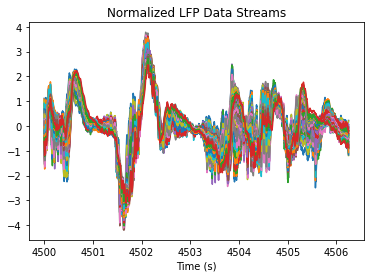

In [118]:
# ======================
# SIGNAL PARAMETERS
# ======================

# unit_indices = [0, 10, 20]
unit_indices = np.where(lfp_areas == 'vlPFC')[0]
# trajectory_start_times = np.arange(0, 7001, 500) # s
start_time = 4500 # s
duration = 6.25 # s


# ------------------
# get signal
# ------------------
start_step = int(start_time/dt)
length = int(duration/dt)
lfp_pts = f['lfp'][unit_indices, start_step:start_step + length].T
# normalize (gaussian normalization)
for i in range(lfp_pts.shape[1]):
    lfp_pts[:, i] = (lfp_pts[:, i] - np.mean(lfp_pts[:, i]))/np.std(lfp_pts[:, i])
var_names = [f"unit_{unit_num} {lfp_areas[unit_num]}" for unit_num in unit_indices]
time_vals = np.arange(start_time, start_time+duration, dt)

for i in range(lfp_pts.shape[1]):
    plt.plot(time_vals, lfp_pts[:, i], label=var_names[i])
plt.xlabel('Time (s)')
plt.title("Normalized LFP Data Streams")
# plt.legend()

plt.show()

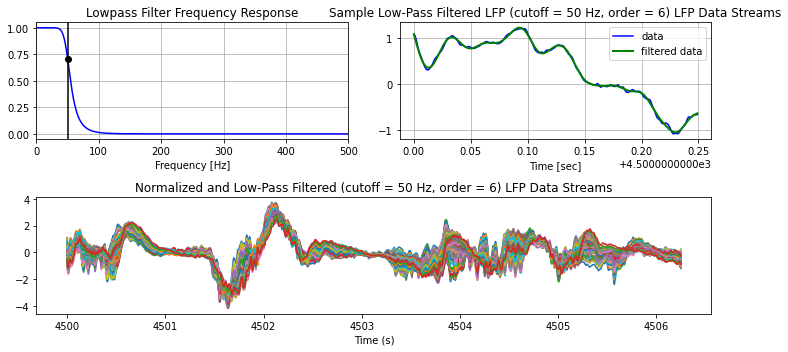

In [119]:
# FILTERING

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Filter requirements.
order = 6
fs = 1/dt      # sample rate, Hz
cutoff = 50  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

plt.figure(figsize=(10, 5))

# Plot the frequency response.
w, h = freqz(b, a, worN=8000)
plt.subplot(2, 2, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

# Demonstrate the use of the filter.
length = 250
data = lfp_pts[:length, 1]

# Filter the data, and plot both the original and filtered signals.
y = butter_lowpass_filter(data, cutoff, fs, order)

plt.subplot(2, 2, 2)
plt.plot(time_vals[:length], data, 'b-', label='data')
plt.plot(time_vals[:length], y, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()
plt.title(f"Sample Low-Pass Filtered LFP (cutoff = {cutoff} Hz, order = {order}) LFP Data Streams")

plt.subplot(2, 1, 2)
for i in range(lfp_pts.shape[1]):
    lfp_pts[:, i] = butter_lowpass_filter(lfp_pts[:, i], cutoff, fs, order)
for i in range(lfp_pts.shape[1]):
    plt.plot(time_vals, lfp_pts[:, i], label=var_names[i])
plt.xlabel('Time (s)')
plt.title(f"Normalized and Low-Pass Filtered (cutoff = {cutoff} Hz, order = {order}) LFP Data Streams")

# plt.subplots_adjust(hspace=0.35)
plt.tight_layout()
plt.show()

In [120]:
# ======================
# RESERVOIR PARAMETERS
# ======================

D_r = 800 # number of reservoir nodes
d = int((6/299)*(D_r-1)) # average degree of Erdos-Renyi network
p = None # probability of an edge in the Erdos-Renyi network - if not None, overrides d
rho = 1.2 # spectral radius of the adjacency matrix

# beta = 0
beta = 1e-5 # regularization parameter
# sigma = 0.1 # maximum value of the input weights
sigma = 1/np.sqrt(300)

squared_inds = None

In [125]:
reservoir = ReservoirDS(lfp_pts, dt=dt, D_r=D_r, d=d, p=p, rho=rho, beta=beta, sigma=sigma, squared_inds=squared_inds, var_names=var_names)
reservoir.train_and_test()

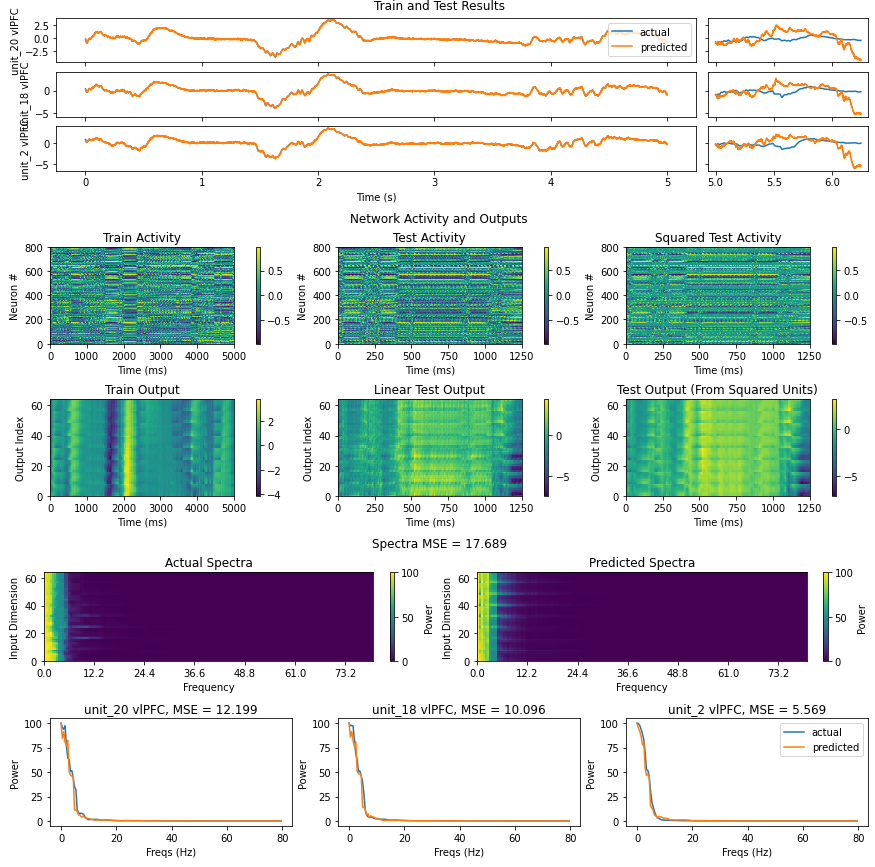

In [126]:
reservoir.plot_all()

In [127]:
reservoir.compute_lyap_spectrum_QR(debug=True)

Computing Jacobians



Computing Lyapunov spectrum


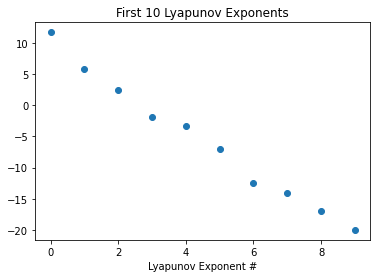

In [128]:
num = 10
plt.scatter(np.arange(num), reservoir.lyaps[:num])
plt.xlabel('Lyapunov Exponent #')
plt.title(f"First {num} Lyapunov Exponents")
plt.show()

## Implementing Gaussian Noise

In [129]:
# ======================
# RESERVOIR PARAMETERS
# ======================

train_noise = 0.1
test_noise = 0

In [130]:
reservoir.train_noise = train_noise
reservoir.test_noise = test_noise
reservoir.train_and_test()

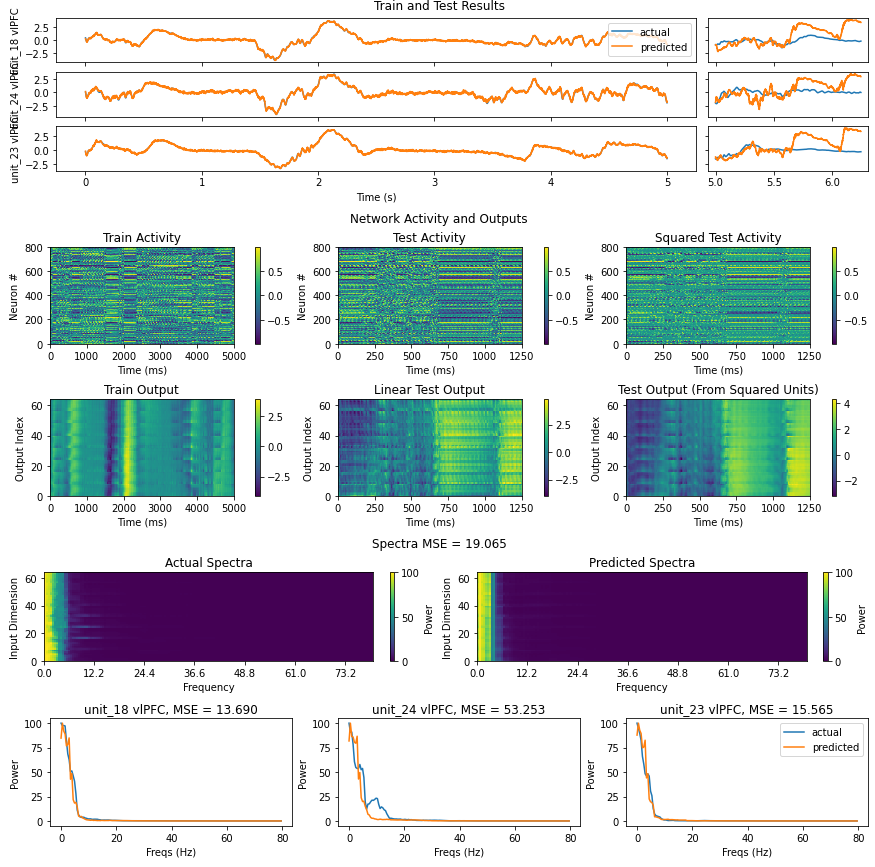

In [131]:
reservoir.plot_all()

In [132]:
reservoir.compute_lyap_spectrum_QR(debug=True)

Computing Jacobians



Computing Lyapunov spectrum


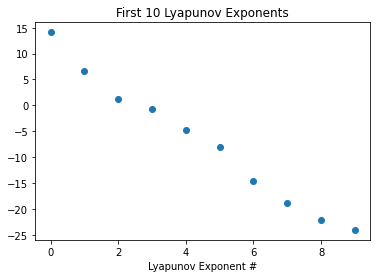

In [133]:
num = 10
plt.scatter(np.arange(num), reservoir.lyaps[:num])
plt.xlabel('Lyapunov Exponent #')
plt.title(f"First {num} Lyapunov Exponents")
plt.show()